Using device: cuda
Loaded 1800 images from 'data'
Epoch [1/30] - Loss: 4027.1988
New best model saved at epoch 1 with loss 4027.1988
Epoch [2/30] - Loss: 1666.5489
New best model saved at epoch 2 with loss 1666.5489
Epoch [3/30] - Loss: 1340.1658
New best model saved at epoch 3 with loss 1340.1658
Epoch [4/30] - Loss: 1295.5035
New best model saved at epoch 4 with loss 1295.5035
Epoch [5/30] - Loss: 1272.4763
New best model saved at epoch 5 with loss 1272.4763


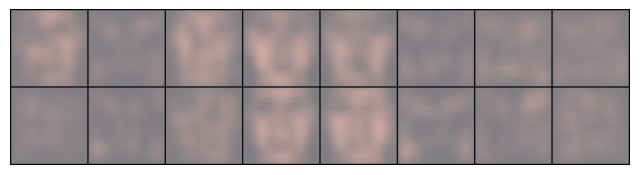

Epoch [6/30] - Loss: 1252.5403
New best model saved at epoch 6 with loss 1252.5403
Epoch [7/30] - Loss: 1134.6145
New best model saved at epoch 7 with loss 1134.6145
Epoch [8/30] - Loss: 1039.7262
New best model saved at epoch 8 with loss 1039.7262
Epoch [9/30] - Loss: 911.3206
New best model saved at epoch 9 with loss 911.3206
Epoch [10/30] - Loss: 821.0012
New best model saved at epoch 10 with loss 821.0012


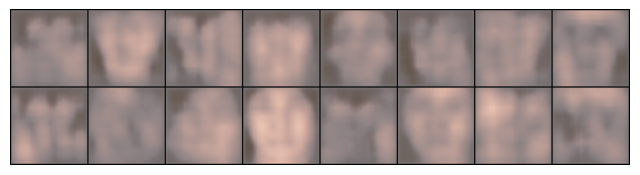

Epoch [11/30] - Loss: 769.2157
New best model saved at epoch 11 with loss 769.2157
Epoch [12/30] - Loss: 723.1526
New best model saved at epoch 12 with loss 723.1526
Epoch [13/30] - Loss: 701.5674
New best model saved at epoch 13 with loss 701.5674
Epoch [14/30] - Loss: 663.2848
New best model saved at epoch 14 with loss 663.2848
Epoch [15/30] - Loss: 643.2633
New best model saved at epoch 15 with loss 643.2633


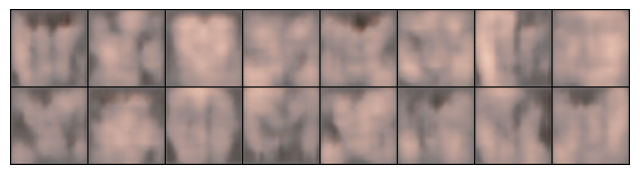

Epoch [16/30] - Loss: 619.2687
New best model saved at epoch 16 with loss 619.2687
Epoch [17/30] - Loss: 600.6531
New best model saved at epoch 17 with loss 600.6531
Epoch [18/30] - Loss: 579.7771
New best model saved at epoch 18 with loss 579.7771
Epoch [19/30] - Loss: 563.3944
New best model saved at epoch 19 with loss 563.3944
Epoch [20/30] - Loss: 541.5996
New best model saved at epoch 20 with loss 541.5996


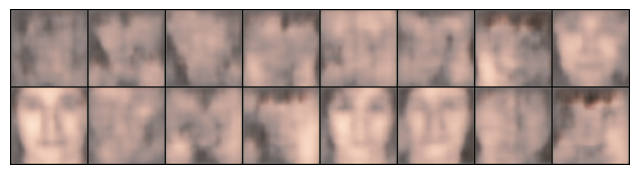

Epoch [21/30] - Loss: 531.3441
New best model saved at epoch 21 with loss 531.3441
Epoch [22/30] - Loss: 522.4217
New best model saved at epoch 22 with loss 522.4217
Epoch [23/30] - Loss: 508.5177
New best model saved at epoch 23 with loss 508.5177
Epoch [24/30] - Loss: 498.4619
New best model saved at epoch 24 with loss 498.4619
Epoch [25/30] - Loss: 490.3927
New best model saved at epoch 25 with loss 490.3927


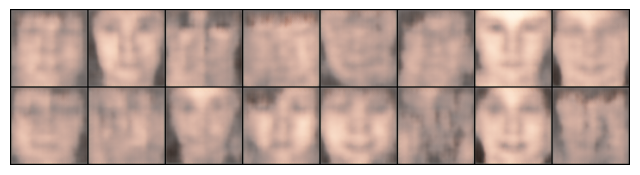

Epoch [26/30] - Loss: 480.2682
New best model saved at epoch 26 with loss 480.2682
Epoch [27/30] - Loss: 474.2047
New best model saved at epoch 27 with loss 474.2047
Epoch [28/30] - Loss: 467.4304
New best model saved at epoch 28 with loss 467.4304
Epoch [29/30] - Loss: 466.0005
New best model saved at epoch 29 with loss 466.0005
Epoch [30/30] - Loss: 457.4685
New best model saved at epoch 30 with loss 457.4685


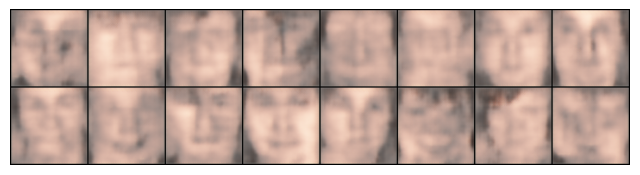

Final model saved to vae_model.pth


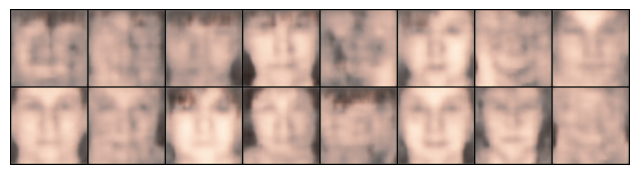

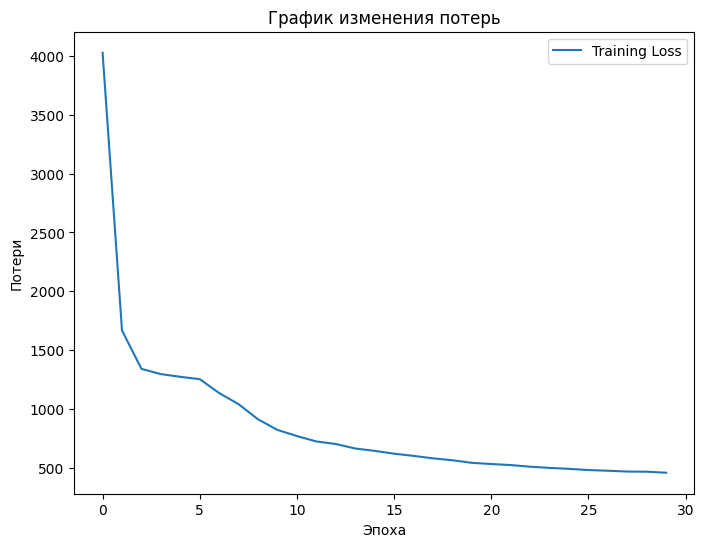

Notification sent! Status Code: 200 | Response Text: SENDING


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision

# -------------------
# Гиперпараметры
# -------------------
BATCH_SIZE = 64
LATENT_DIM = 128
IMAGE_SIZE = 128  # Размер изображения (кратно 16)
EPOCHS = 30
LEARNING_RATE = 1e-3
SAVE_PATH = './models/vae_model.pth'
BEST_MODEL_PATH = './models/vae_best_model.pth'
SAVE_INTERVAL = 50  # Интервал сохранения сгенерированных изображений
OLD_MODEL = False  # Путь к старой модели (если есть)

#Folders
OUTPUT = './output'
EPOCHS_FOLDER = os.path.join(OUTPUT, 'epochs')
GENERATED_FOLDER = os.path.join(OUTPUT, 'generated')
MORPH_FOLDER = os.path.join(OUTPUT, 'morph_frames')
Z_FOLDER = os.path.join(OUTPUT, 'z_frames')
LAT_GRID = os.path.join(OUTPUT, 'latent_frames')
GRID_FOLDER = os.path.join(OUTPUT, 'grid')
os.makedirs(OUTPUT, exist_ok=True)
os.makedirs(os.path.dirname(EPOCHS_FOLDER), exist_ok=True)
os.makedirs(os.path.dirname(GENERATED_FOLDER), exist_ok=True)
os.makedirs(os.path.dirname(MORPH_FOLDER), exist_ok=True)
os.makedirs(os.path.dirname(Z_FOLDER), exist_ok=True)
os.makedirs(os.path.dirname(LAT_GRID), exist_ok=True)
os.makedirs(os.path.dirname(GRID_FOLDER), exist_ok=True)

# -------------------
# Устройство
# -------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------
# Подготовка данных
# -------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Loaded {len(dataset)} images from 'data'")

# -------------------
# Определение модели
# -------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"
        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        layers = []
        in_channels = 3
        for _ in range(num_layers):
            out_channels = in_channels * 2
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        self.conv = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(in_channels * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"
        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        self.start_channels = 3 * (2 ** num_layers)
        self.fc = nn.Linear(latent_dim, self.start_channels * 4 * 4)
        layers = []
        in_channels = self.start_channels
        for _ in range(num_layers):
            out_channels = in_channels // 2
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers[-2] = nn.ConvTranspose2d(in_channels * 2, 3, 4, 2, 1)
        layers[-1] = nn.Sigmoid()
        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.start_channels, 4, 4)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.encoder = Encoder(latent_dim, img_size)
        self.decoder = Decoder(latent_dim, img_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

# -------------------
# Вспомогательные функции
# -------------------
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('График изменения потерь')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# -------------------
# Инициализация модели
# -------------------
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(device)
if OLD_MODEL:
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=device))
    print("Loaded model from", OLD_MODEL)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# -------------------
# Обучение модели
# -------------------
losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}')

    # Сохраняем лучшую модель
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(vae.state_dict(), BEST_MODEL_PATH)
        print(f"New best model saved at epoch {epoch+1} with loss {best_loss:.4f}")
 
    # Периодически генерируем изображения
    if (epoch + 1) % SAVE_INTERVAL == 0:
        vae.eval()
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(device)
            samples = vae.decoder(z)
        vutils.save_image(samples.cpu(), f'{EPOCHS_FOLDER}/generated_faces_epoch_{epoch+1}.png', nrow=4)
        imshow(torchvision.utils.make_grid(samples.cpu()))

# -------------------
# Сохранение финальной модели
# -------------------
torch.save(vae.state_dict(), SAVE_PATH)
print(f"Final model saved to {SAVE_PATH}")

# -------------------
# Генерация итоговых лиц
# -------------------
vae.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(device)
    samples = vae.decoder(z)
vutils.save_image(samples.cpu(), f'{GENERATED_FOLDER}/generated_faces_final.png', nrow=4)
imshow(torchvision.utils.make_grid(samples.cpu()))

# -------------------
# Построение графика потерь
# -------------------
plot_loss(losses)

# -------------------
# Уведомление о завершении обучения
# -------------------
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")


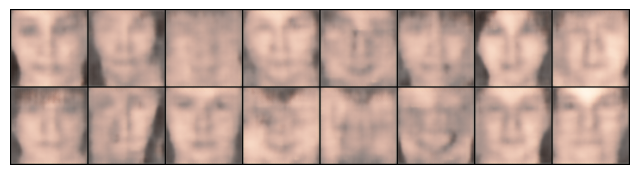

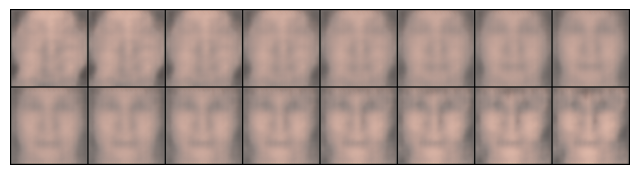

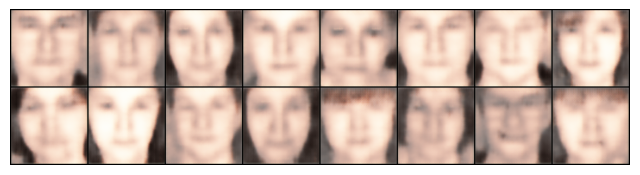

C:\Users\mit\AppData\Local\Temp\ipykernel_20996\4184096968.py:81: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


GIF морфинга сохранён как 'morphing.gif'


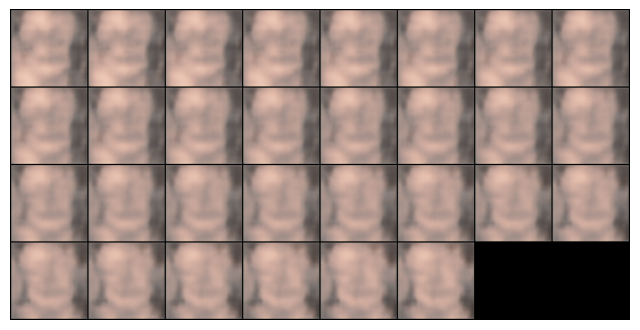

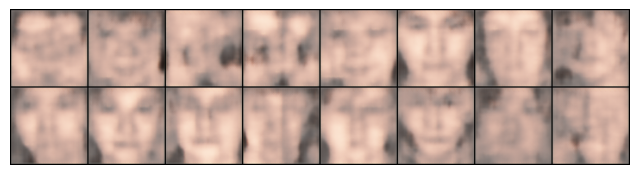

In [ ]:
# Продолжение для работы с обученным VAE
# Генерация разных типов z для декодера и создание GIF морфинга

import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import imageio

# --- Функции визуализации ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Настройки ---
NUM_PIC = 16  # Количество изображений
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель уже загружена как "vae"
vae.eval()

 

# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 2. Ручное задание признаков ---
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'{MORPH_FOLDER}/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave(f'{MORPH_FOLDER}/morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), f'{Z_FOLDER}z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(-2, 2).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))


Сетка лиц сохранена в grid_faces_0_1.png


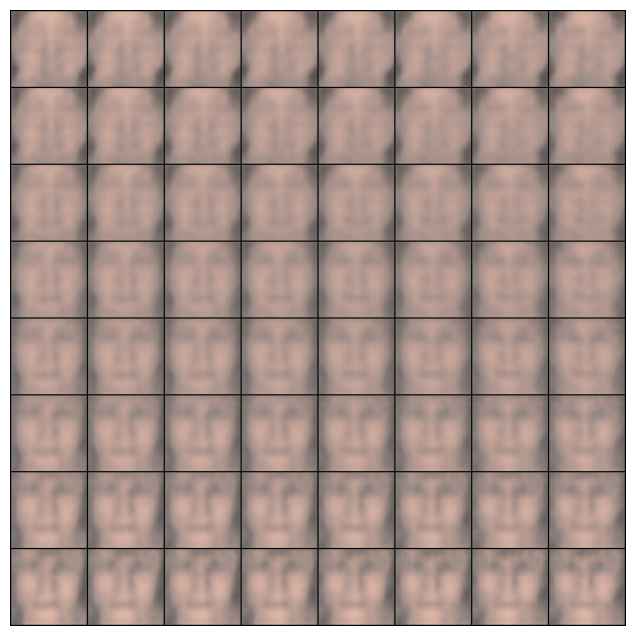

Сетка лиц сохранена в grid_faces_2_3.png


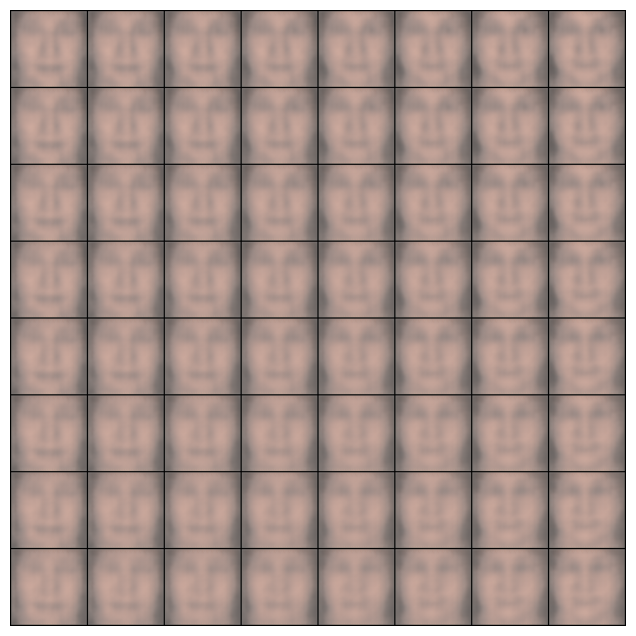

Сетка лиц сохранена в grid_faces_5_6.png


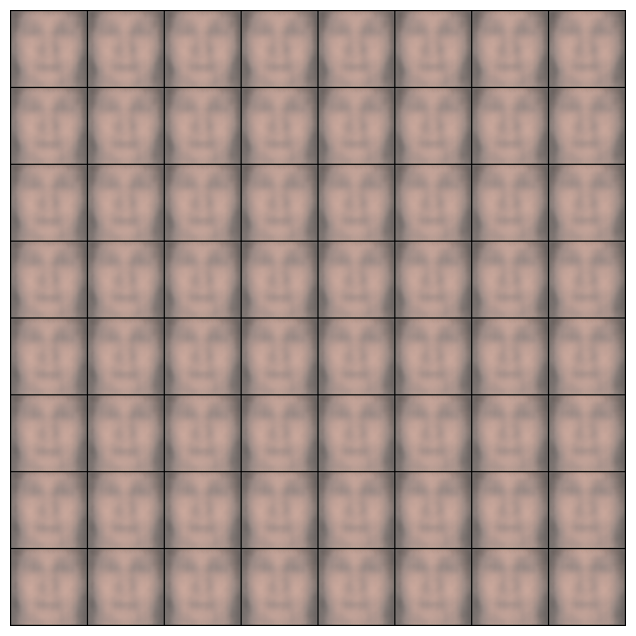

C:\Users\mit\AppData\Local\Temp\ipykernel_20996\4166612776.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


Анимация латентного перехода сохранена в latent_walk.gif


In [ ]:
# Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os
import imageio

# --- Настройки ---
LATENT_DIM = 128
GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

# --- Функция отображения изображений ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='latent_walk.gif'):
    frames = []
  
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'{LAT_GRID}/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

# --- Примеры использования ---

# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path=f'{GRID_FOLDER}grid_faces_0_1.png')

# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(2, 3), range_min=-2, range_max=2)
generate_face_grid(z, save_path=f'{GRID_FOLDER}grid_faces_2_3.png')

# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path=f'{GRID_FOLDER}grid_faces_5_6.png')

# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 1), steps=40, save_path=f'{OUTPUT}latent_walk.gif')
